In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import pandas as pd
from scipy.spatial import distance as ssd
import numpy as np

/Users/bidas/Documents/GitHub/abcd-dictionary-chatbot/dev/py-notebooks/satra/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Data dictionary

The voice dataset has many different fields. This notebook introduces a semantic search of those fields.

Let's first read the the data dictionary into a pandas dataframe.

In [3]:
# CHANGE TO THE PATH TO YOUR DIRECTORY
rcdict_all = pd.read_csv('~/Documents/GitHub/abcd-dictionary-chatbot/data/dd-abcd-6_0_minimal.csv')
rcdict_all.head()

,source,domain,sub_domain,table_name,table_label,name,label,unit,type_var,type_data,type_level,substudy
0,General,ABCD (General),Standard Variables,ab_g_dyn,ABCD Dynamic Variables [General],ab_g_dyn__visit_dtt,Visit information: Date and time at the start ...,NaN,administrative,timestamp,interval,False
1,General,ABCD (General),Standard Variables,ab_g_dyn,ABCD Dynamic Variables [General],ab_g_dyn__visit_age,Visit information: Youth's age at the start of...,years (yr),administrative,double,ratio,False
2,General,ABCD (General),Standard Variables,ab_g_dyn,ABCD Dynamic Variables [General],ab_g_dyn__visit_type,"Visit information: Type of visit (In-person, r...",NaN,administrative,character,nominal,False
3,General,ABCD (General),Standard Variables,ab_g_dyn,ABCD Dynamic Variables [General],ab_g_dyn__visit_days,Visit information: Number of visit days,NaN,administrative,integer,ratio,False
4,General,ABCD (General),Standard Variables,ab_g_dyn,ABCD Dynamic Variables [General],ab_g_dyn__visit__day1_dt,Visit information (day 1): Visit date,NaN,administrative,date,interval,False


In [ ]:
# Subset a few rows
# rcdict = rcdict_all.iloc[0:10000]
rcdict = rcdict_all

In [5]:
len(rcdict['label'])

10000

In [6]:
sentences = rcdict['label'].values.tolist()
print(len(sentences))
sentences[:10]

10000


['Visit information: Date and time at the start of the visit',
 "Visit information: Youth's age at the start of the event",
 'Visit information: Type of visit (In-person, remote, hybrid)',
 'Visit information: Number of visit days',
 'Visit information (day 1): Visit date',
 'Visit information (day 2): Visit date',
 'Visit information (day 3): Visit date',
 'Visit information (day 4): Visit date',
 "Visit information (day 1): Informant's relationship to participant",
 "Visit information (day 2): Informant's relationship to participant"]

#### Turning sentences into numbers

We will use MiniLM model from HuggingFace for generating sentence embeddings

In [7]:
#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

The model has been downloaded from HuggingFace. If you are running this on your own own setup, replace:

`'models/sentence-transformers/all-MiniLM-L6-v2' --> 'sentence-transformers/all-MiniLM-L6-v2'`

in the two places in the code below

In [8]:
def embed_sentences(text_list):
    # Load model from HuggingFace Hub
    tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
    
    # Tokenize sentences
    encoded_input = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
    
    # Compute token embeddings
    with torch.no_grad():
        model_output = model(**encoded_input)
    
    # Perform pooling
    sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    
    # Normalize embeddings
    sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)    
    return sentence_embeddings

Let's turn all the sentences into embeddings. Vectors that represent aspects of semantic meaning of the sentence.

In [9]:
embeddings = embed_sentences(sentences)

In [10]:
np.array(embeddings).shape

/var/folders/dr/2m_7jrns2wg6g3ykb1r7f5p00000gn/T/ipykernel_20240/1521927839.py:1: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(embeddings).shape


(10000, 384)

This is where we get to define search query. Feel free to replace the string with your own.

In [25]:
search_string = 'variables to compute body mass index'
search_embedding = embed_sentences([search_string,])

In [26]:
# Compute cosine similarity scores for the search string to all other sentences
sims = []
for embedding in embeddings:
    sims.append(1 - ssd.cosine(search_embedding[0], embedding))

In [27]:
# Sort sentences by similarity score in descending order (the most similar ones are first)
sorted_index = np.argsort(sims)[::-1]
sentences_sorted = np.array(sentences)[sorted_index]
sims = np.array(sims)[sorted_index]

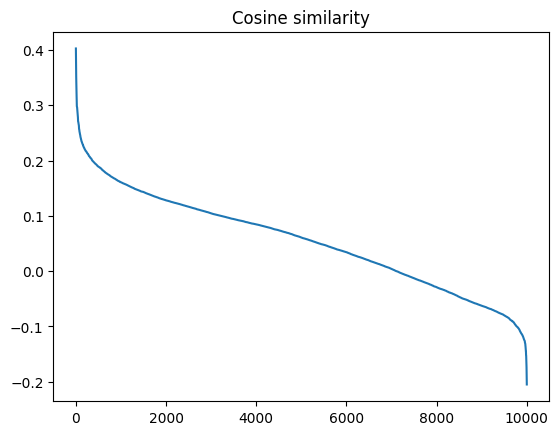

In [28]:
plt.plot(sims)
plt.title("Cosine similarity");

Select a cutoff value from the figure where you notice a bending of the elbow.

In [29]:
cutoff = 0.3
sentences_sorted[sims > cutoff].tolist()

['I am overweight [Youth; YSR item 55]',
 'Obesity among adults aged >=18 years; Prevalence [PLACES] (Address 2) (address 2)',
 'Obesity among adults aged >=18 years; Prevalence [PLACES] (Address 3) (address 3)',
 'Obesity among adults aged >=18 years; Prevalence [PLACES] (Address 1) (address 1)',
 'Adult Self Report [Parent] (Adaptive Functioning Scale - Personal strength): Number missing',
 "Cohort description: Participant's sex",
 'Overweight [CBCL item 55}',
 'Is weight within acceptable range for MRI? (under 250 lbs)',
 "What is your child's weight?",
 'Adult Self Report [Parent] (Adaptive Functioning Scale - Personal strength): Sum\n[Validation: No more than 0 missing or declined]',
 'Symptom: Self-worth tied to weight - Present [Youth]',
 'Scaled weighted sum [Area Deprivation Index (based on Kind et al., Annals of Internal Medicine, 2012)] (Address 3) (address 3)',
 'Scaled weighted sum [Area Deprivation Index (based on Kind et al., Annals of Internal Medicine, 2012)] (Address 

Reorder the dataframe according to the sorted index to retrieve variable names

In [30]:
rcdict.loc[sorted_index[sims > cutoff], :]

,source,domain,sub_domain,table_name,table_label,name,label,unit,type_var,type_data,type_level,substudy
8133,Youth,Mental Health,Broad Psychopathology,mh_y_ysr,Youth Self Report [Youth],mh_y_ysr__othpr_004,I am overweight [Youth; YSR item 55],NaN,item,character,ordinal,False
2503,Linked Dataset,Linked External Data,Community Health Burden,le_l_places,Behavioral Health Measures (PLACES) [Linked Da...,le_l_places__addr2__obesity_preval,Obesity among adults aged >=18 years; Prevalen...,NaN,summary score,double,ratio,False
2531,Linked Dataset,Linked External Data,Community Health Burden,le_l_places,Behavioral Health Measures (PLACES) [Linked Da...,le_l_places__addr3__obesity_preval,Obesity among adults aged >=18 years; Prevalen...,NaN,summary score,double,ratio,False
2475,Linked Dataset,Linked External Data,Community Health Burden,le_l_places,Behavioral Health Measures (PLACES) [Linked Da...,le_l_places__addr1__obesity_preval,Obesity among adults aged >=18 years; Prevalen...,NaN,summary score,double,ratio,False
4249,Parent,Mental Health,Broad Psychopathology,mh_p_asr,Adult Self Report [Parent],mh_p_asr__afs__strng_nm,Adult Self Report [Parent] (Adaptive Functioni...,NaN,summary score,integer,ratio,False
39,General,ABCD (General),Standard Variables,ab_g_stc,ABCD Static Variables [General],ab_g_stc__cohort_sex,Cohort description: Participant's sex,NaN,summary score,character,nominal,False
4341,Parent,Mental Health,Broad Psychopathology,mh_p_cbcl,Child Behavior Checklist [Parent],mh_p_cbcl__othpr_005,Overweight [CBCL item 55},NaN,item,character,ordinal,False
449,Parent,ABCD (General),Screener,ab_p_screen,Screener (Study Eligibility) [Parent],ab_p_screen__weight_001__01,Is weight within acceptable range for MRI? (un...,NaN,item,character,nominal,False
448,Parent,ABCD (General),Screener,ab_p_screen,Screener (Study Eligibility) [Parent],ab_p_screen__weight_001,What is your child's weight?,pounds (lb),item,integer,ratio,False
4250,Parent,Mental Health,Broad Psychopathology,mh_p_asr,Adult Self Report [Parent],mh_p_asr__afs__strng_sum,Adult Self Report [Parent] (Adaptive Functioni...,NaN,summary score,integer,interval,False
